# Single analysis notebook

This notebook aims to create enviroment to simply test strategies developed in Stocks & Loss system for python

In [13]:
# imports 
from scraper import stock_daily
from analyzer import Analyzer
from IPython.display import display

import datetime as dt
import numpy as np
import matplotlib.pyplot as plt

## Settings
* Select stock ticker
* Define buy and sell strategy (buystrat and sellstrat)
* Define if you want to run stop loss and what value
* Same with profit taker

In [14]:
ticker = "SLAB"

buystrat = ["Mcstoch_ut1", "Mcstoch_ut2", "Mcstoch_ut3", "Mcstoch_ut4", "Mcstoch_dt1"]
sellstrat = ['Mcstoch']

sl = True
slval = 0.05

pt = True
ptval = 0.1

rb = True

## Run calculation

In [15]:
# scraping / loading data
stock = stock_daily(ticker, delta=dt.timedelta(days=365),save=False)
# creating analyzer instance
trades = Analyzer(ticker=ticker, data=stock.data)
#running methods for buy signals
Mcstoch_ut1= trades.methodBuy_Mcstoch_ut1()
Mcstoch_ut2= trades.methodBuy_Mcstoch_ut2()
Mcstoch_ut3= trades.methodBuy_Mcstoch_ut3()
Mcstoch_ut4= trades.methodBuy_Mcstoch_ut4()
Mcstoch_dt1= trades.methodBuy_Mcstoch_dt1()
buySignal1 = trades.signalOr(Mcstoch_ut1, Mcstoch_ut2)
buySignal2 = trades.signalOr(Mcstoch_ut3, Mcstoch_ut4)
buySignal3 = trades.signalOr(buySignal1, buySignal2)
buySignal_final = trades.signalOr(buySignal3, Mcstoch_dt1)
# throw exception if buy signal is empty
if buySignal_final.sum() == 0:
    raise RuntimeError("No buy signals were generated by this strategy.")

# for N buy signals, create N sell vectors where Nth column will be the sell signal for Nth buy signal, 
# some sell methods that are independent will have copied columns
sellSignal = trades.methodSell_Mcstoch()
sellSignal_final = np.repeat([sellSignal,], repeats=np.sum(buySignal_final), axis=0)
sorted_signals = trades.signalSorter(buySignal_final,sellSignal_final,rb)  

    
# building strategy
trades.strategy(sorted_signals,
    stopLoss=sl ,stopLossValue=slval, profitTaker=pt, profitTakerValue=ptval)
# evaluating strategy
summary = trades.profit(capitalForEachTrade=400, comission=2)
profitByHolding = 100*((trades.data["Close"].iloc[-1]-trades.data["Close"].iloc[0])/trades.data["Close"].iloc[0])

# dates for plot
# taking stock.data and changing index to column and Date to index
dates = stock.data.copy()
dates["index1"] = dates.index
dates = dates.set_index("Date")

# find index of buy dates of good trades
bdg = summary["Buy date"].where(summary["Good trade?"].astype("bool")).dropna().to_numpy()
sdg = summary["Sell date"].where(summary["Good trade?"].astype("bool")).dropna().to_numpy()
bdg = dates["index1"].reindex(bdg).to_numpy()
sdg = dates["index1"].reindex(sdg).to_numpy()
   
# find index of buy dates of bad trades
bdb = summary["Buy date"].where(~summary["Good trade?"].astype("bool")).dropna().to_numpy()
sdb = summary["Sell date"].where(~summary["Good trade?"].astype("bool")).dropna().to_numpy()
bdb = dates["index1"].reindex(bdb).to_numpy()
sdb = dates["index1"].reindex(sdb).to_numpy()

In [16]:
print('Absolute profit last year:                ',np.round(summary["Profit[$]"].sum(),2),'$')
print('Relative profit last year:                ',np.round(summary["Profit[%]"].sum(),2),'%')
print('Relative profit by holding last year:     ',np.round(profitByHolding,2),'%')

Absolute profit last year:                 184.29 $
Relative profit last year:                 46.07 %
Relative profit by holding last year:      38.98 %


In [17]:
display(summary)

,Buy date,Buy price,Buy value,Position,Sell date,Sell price,Sell value,Comission,Good trade?,Profit[%],Profit[$]
0,2020-10-08,101.389999,400,3.945162,2020-10-26,101.940002,402.169851,2,1.0,0.042463,0.169851
1,2020-10-29,104.529999,400,3.826653,2020-11-09,114.982999,440.000000,2,1.0,9.500000,38.000000
2,2020-11-03,103.739998,400,3.855793,2020-11-06,114.113998,440.000000,2,1.0,9.500000,38.000000
3,2020-11-04,106.040001,400,3.772161,2020-11-09,116.644001,440.000000,2,1.0,9.500000,38.000000
4,2020-11-23,113.070000,400,3.537632,2020-11-25,113.389999,401.132041,2,1.0,-0.216990,-0.867959
5,2020-11-30,117.209999,400,3.412678,2020-12-14,121.349998,414.128485,2,1.0,3.032121,12.128485
6,2020-12-15,125.860001,400,3.178134,2020-12-22,125.320000,398.283805,2,0.0,-0.929049,-3.716195
7,2020-12-31,127.339996,400,3.141197,2021-01-04,126.349998,396.890222,2,0.0,-1.277445,-5.109778
8,2021-01-06,132.880005,400,3.010235,2021-01-27,131.529999,395.936165,2,0.0,-1.515959,-6.063835
9,2021-02-01,137.350006,400,2.912268,2021-02-11,151.085007,440.000000,2,1.0,9.500000,38.000000


## Visualizations

Successful trades are showcased as a light green fill, similarly, failed trades as a red fill

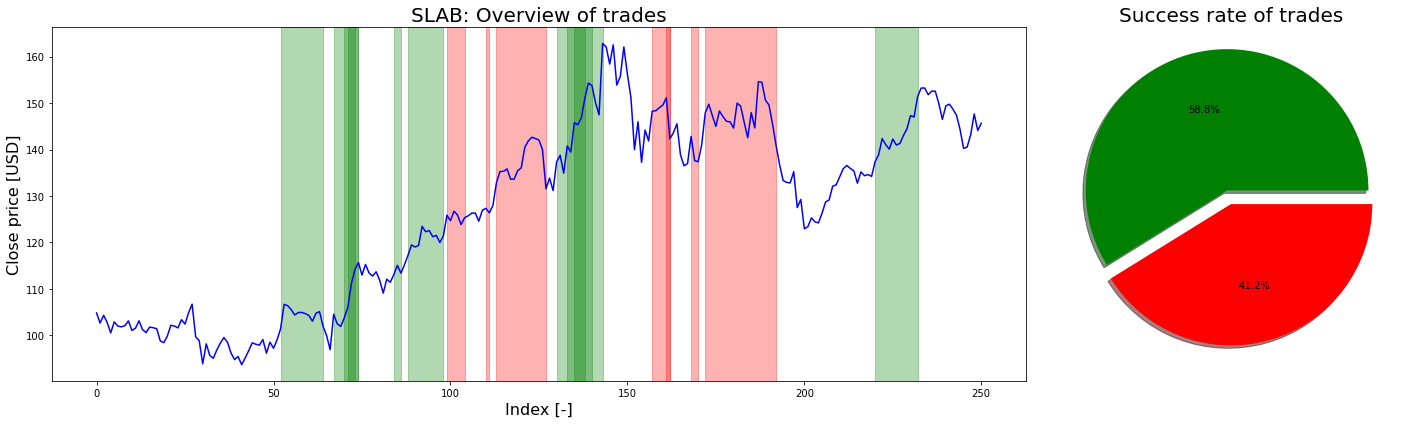

In [18]:
fig, ax = plt.subplots(ncols=2, figsize=(20,6), gridspec_kw={'width_ratios': [2.5, 1]})

# plot closed prices and highlighted trades
ax[0].plot(stock.data["Close"], color="b")
for i, val in enumerate(bdg):
    ax[0].axvspan(val, sdg[i], alpha=0.3, color="g")
for i, val in enumerate(bdb):
    ax[0].axvspan(val, sdb[i], alpha=0.3, color="r")
ax[0].set_title(ticker + ": Overview of trades", fontsize=20)
ax[0].set_ylabel("Close price [USD]", fontsize=16)
ax[0].set_xlabel("Index [-]", fontsize=16)

gtrades = summary["Good trade?"].sum()
trades = summary["Good trade?"].size
# plot piechart with percentage of succesful trades (profit / loss)
ax[1].pie([gtrades, trades-gtrades], colors=["g","r"], shadow=True, explode=(0.1, 0), autopct="%1.1f%%")
ax[1].set_title("Success rate of trades", fontsize=20)

fig.tight_layout()